# Face Landmarks

Using a subset of [UMD Faces](http://umdfaces.io) database to train a face landmarks predicting model.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
from multiprocessing import Pool
from os.path import join
from pathlib import Path
from copy import deepcopy
import random
import math
import sys

In [3]:
try:
    old_path
except NameError:
    old_path = sys.path
    new_path = [str(Path.cwd()/'loop')] + old_path
    sys.path = new_path

In [4]:
import pandas as pd
import numpy as np
import cv2 as cv
import PIL.Image
from imageio import imread
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.ticker as mtick
from pandas_summary import DataFrameSummary
from tqdm import tqdm_notebook as tqdm

In [5]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import models
from torchvision.transforms.functional import to_tensor, normalize
from fastai.core import defaults

In [24]:
from basedir import DATA, META, CROPPED, NUM_LANDMARKS
from plot import to_absolute, show, show_random_grid

In [7]:
SEED = 1
DEVICE = torch.device('cuda:1')
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
defaults.device = DEVICE

---
## Reading Cropped Images

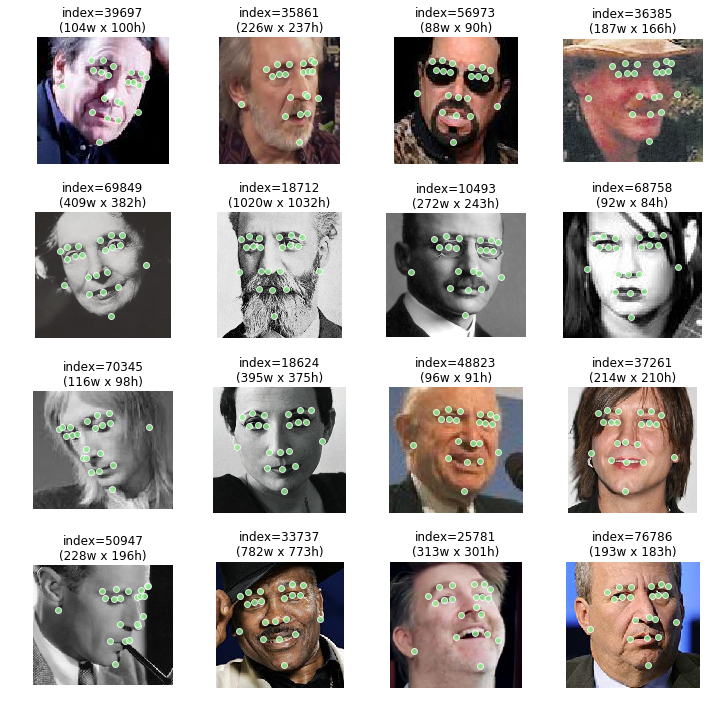

In [27]:
show_random_grid(CROPPED)

Ok, it seems that each sample includes (at least) one human in various poses with various backgrounds. Therefore, our first goal is to convert this dataset into a more suitable format before we processed with training the model. The most straightforward way to do so is to _crop_ the faces only and save them into smaller files.

## Data Preparation

In [45]:
from fastai.vision import PointsItemList, ItemList

In [57]:
def files_with_indexes(root, ids, suffix=('.jpeg',)):
    return [fn for fn in root.ls() if fn.suffix in suffix and int(fn.stem) in ids]

In [98]:
def read_landmarks(img_path):
    index = img_path.stem
    pts_path = img_path.parent/f'{index}.txt'
    img = imread(img_path)
    h, w = img.shape[:2]
    pts = np.loadtxt(pts_path, delimiter=',')
    xs, ys = pts[:, 1], pts[:, 0]
    xs, ys = to_absolute(xs, ys, w, h)
    return torch.FloatTensor(np.c_[ys, xs])

In [99]:
n_files = len(CROPPED.ls())//2
trn_idx, val_idx = train_test_split(np.arange(n_files), test_size=0.1, random_state=SEED)
print(f'Train size: {len(trn_idx)}, valid size: {len(val_idx)}')

Train size: 69505, valid size: 7723


In [100]:
p = PointsItemList.from_folder(CROPPED)

In [101]:
p = p.split_by_idxs(trn_idx, val_idx)

In [102]:
p = p.label_from_func(read_landmarks)

In [104]:
p

LabelLists;

Train: LabelList
y: PointsLabelList (69505 items)
[ImagePoints (330, 367), ImagePoints (275, 288), ImagePoints (507, 504), ImagePoints (300, 317), ImagePoints (327, 339)]...
Path: /home/ck/data/umdfaces/cropped
x: PointsItemList (69505 items)
[Image (3, 330, 367), Image (3, 275, 288), Image (3, 507, 504), Image (3, 300, 317), Image (3, 327, 339)]...
Path: /home/ck/data/umdfaces/cropped;

Valid: LabelList
y: PointsLabelList (7723 items)
[ImagePoints (79, 81), ImagePoints (316, 306), ImagePoints (184, 162), ImagePoints (166, 175), ImagePoints (139, 152)]...
Path: /home/ck/data/umdfaces/cropped
x: PointsItemList (7723 items)
[Image (3, 79, 81), Image (3, 316, 306), Image (3, 184, 162), Image (3, 166, 175), Image (3, 139, 152)]...
Path: /home/ck/data/umdfaces/cropped;

Test: None

In [ ]:
def conv(ni, no, kernel, stride, groups=1, lrn=False, bn=False, pool=None, activ='prelu'):
    layers = [nn.Conv2d(ni, no, kernel, stride, groups=groups)]
    activation = {
        'relu': nn.ReLU(inplace=True),
        'prelu': nn.PReLU(),
        'linear': None
    }[activ]
    if activation is not None:
        layers += [nn.PReLU()]
    if lrn:
        layers.append(nn.LocalResponseNorm(2))
    elif bn:
        layers.append(nn.BatchNorm2d(no))
    if pool is not None:
        layers.append(nn.MaxPool2d(*pool))
    return layers


def fc(ni, no, bn=True, activ='linear', dropout=None):
    layers = [nn.Linear(ni, no)]
    if bn:
        layers.append(nn.BatchNorm1d(no))
    if activ is not None:
        activation = {
            'relu': nn.ReLU(inplace=True),
            'prelu': nn.PReLU(),
            'linear': None
        }[activ]
        if activation is not None:
            layers.append(activation)
    if dropout is not None:
        layers.append(nn.Dropout(dropout))
    return layers


class InitShapeEstimator(nn.Module):
    """Network to predict initial shape S(0) of landmarks.
    
    Convolution layer C(n, k, g, s):
        n = kernel number
        k = kernel siznn.Sequential   g = group number
        s = stride
    
    Pooling layer P(k, s):
        k = kernel size
        s = stride
        
    """
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList(
            conv(3, 24, 11, 4, lrn=True, pool=(3, 2)) +
            conv(24, 64, 5, 1, lrn=True, pool=(3, 2), groups=2) +
            conv(64, 196, 3, 1) +
            conv(196, 196, 3, 1, groups=2) +
            conv(196, 96, 3, 1, groups=2) +
            [Flatten()] + 
            fc(1536, 1024, bn=False, activ='prelu', dropout=0.25) +
            fc(1024, 1024, bn=False, activ='prelu', dropout=0.25) +
            fc(1024, NUM_LANDMARKS, bn=False)
        )
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    
def generate_patches(landmarks, image):
    pass


def generate_patch(x, y, w, h, image):
    patch = torch.tensor(3, h, w, type=image.type())
    for q in range(h):
        for p in range(w):
            yq = y + q - (h - 1)/2
            xp = x + p - (w - 1)/2
            xd = 1 - (xp - math.floor(xp))
            xu = 1 - (math.ceil(xp) - xp)
            yd = 1 - (yp - math.floor(yp))
            yu = 1 - (math.ceil(yq) - yq)
            patch[:, q, p] = (
                image[:, math.floor(yq), math.floor(xp)]*yd*xd + 
                image[:, math.floor(yq),  math.ceil(xp)]*yd*xu +
                image[:,  math.ceil(yq), math.floor(xp)]*yu*xd +
                image[:,  math.ceil(yq),  math.ceil(xp)]*yu*xu
            )
    return patch

class ResidualModel(nn.Module):
    """Network to adjust landmark position using input from the previous network."""
    def __init__(self):
        super().__init__()
        self.conv1 = conv(3, 16, 6, 2, bn=True, activ='relu')
        self.conv2 = conv(16, 16, 3, 1, bn=True, activ='relu')
        self.flatten = Flatten()
        self.fc1 = fc(128, 128, bn=True, activ='relu')
        self.fc2 = fc(128, NUM_LANDMARKS, bn=False)
    
    def forward(self, s, x):
        acts = []
        for p in generate_patches(s, x):
            p = self.conv1(p)
            p = self.conv2(p)
            acts.append(p)
        x = torch.concat(acts)
        x = self.fc1(x)
        x = self.fc2(x)
        return x